In [1]:
import gc
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
PATIENCE = 5
MIN_DELTA = 0.01
IMG_SHOW_NUM = 6

In [4]:
transformer = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE), antialias = True),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

testTransformer = transforms.Compose([
    transforms.Resize(size = (IMG_SIZE, IMG_SIZE), antialias = True),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

In [5]:
trainData = datasets.ImageFolder(root = "/Users/christan/Desktop/skin-cancer-group-2/data/train", transform = transformer)
testSet = datasets.ImageFolder(root = "/Users/christan/Desktop/skin-cancer-group-2/data/test", transform = testTransformer)

trainSet, valSet = torch.utils.data.random_split(trainData, [int(0.8 * len(trainData)), len(trainData) - int(0.8 * len(trainData))])

In [6]:
trainLoader = DataLoader(trainSet, batch_size = BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valSet, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(testSet, batch_size = BATCH_SIZE, shuffle = False)

In [7]:
print('Train: ', len(trainSet))
print('Validation: ', len(valSet))
print('Test: ', len(testSet))

Train:  2109
Validation:  528
Test:  660


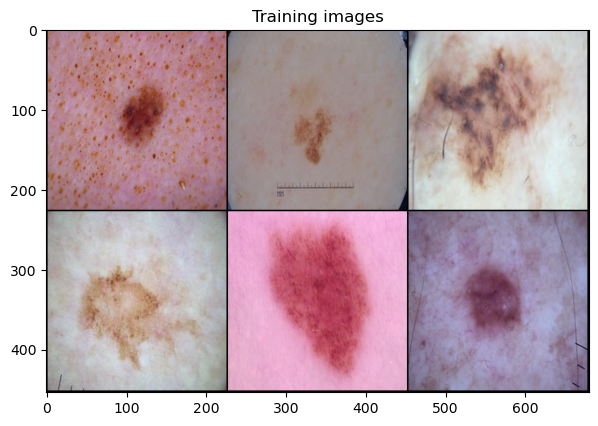

In [8]:
def show_images(imgs, title):
    grid = utils.make_grid(imgs, nrow = 3, padding = 2, normalize=True)
    plt.figure(figsize = (7, 10))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(title)

dataiter = iter(trainLoader)
images, labels = next(dataiter)
show_images(images[:IMG_SHOW_NUM], title = "Training images")

In [9]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [10]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
train_loader = DeviceDataLoader(trainLoader, device)
val_loader = DeviceDataLoader(valLoader, device)
test_loader = DeviceDataLoader(testLoader, device)

In [12]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

to_device(model, device)

criterion= nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

currentPatience = 0
bestLoss = float("inf")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.01, factor=0.1, patience=3, min_lr=1e-5, verbose=True)

losses_train, losses_val = [], []
accuracies_train, accuracies_val = [], []

for epoch in range(EPOCHS): 
    print()
    print(f'EPOCH {epoch+1}') 
    print()

    model.train(True)

    running_loss, last_loss, avg_loss = 0., 0., 0.
    train_correct, train_total = 0, 0
    
    for i, data in enumerate(train_loader):
        input, label = data
        optimizer.zero_grad()

        outputs = model(input)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss += loss.item()

        if i % 10 == 0:
            last_loss = running_loss / 10
            print(f'Batch {i} Loss train: {last_loss:.3f}')
            running_loss = 0.
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()

        torch.cuda.empty_cache()
        _ = gc.collect()

    avg_loss /= int(len(trainSet)/BATCH_SIZE)
    
    running_vloss = 0.
    
    model.eval()

    val_correct, val_total = 0, 0

    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            val_input, val_label = val_data
            val_output = model(val_input)
            val_loss = criterion(val_output, val_label)
            running_vloss += val_loss.item()

            _, vpredicted = torch.max(val_output.data, 1)
            val_total += val_label.size(0)
            val_correct += (vpredicted == val_label).sum().item()

    avg_vloss = running_vloss / (i + 1)

    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total

    losses_train.append(avg_loss)
    losses_val.append(avg_vloss)
    accuracies_train.append(train_accuracy)
    accuracies_val.append(val_accuracy)

    print(f'Loss train {avg_loss:.3f}, loss valid {avg_vloss:.3f}')
    print(f'Accuracy train {train_accuracy:.2%}, accuracy valid {val_accuracy:.2%}')

    if avg_vloss < bestLoss - MIN_DELTA:
        bestLoss = avg_vloss
        currentPatience = 0
    else:
        currentPatience += 1
        if currentPatience >= PATIENCE:
            print("EARLY STOPPING")
            break
    
    scheduler.step(avg_vloss)

print("FINISH TRAINING")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/christan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:00<00:00, 48.8MB/s]
/Users/christan/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



EPOCH 1

Batch 0 Loss train: 0.076
Batch 10 Loss train: 0.387
Batch 20 Loss train: 0.364
Batch 30 Loss train: 0.409
Batch 40 Loss train: 0.335
Batch 50 Loss train: 0.357
Batch 60 Loss train: 0.383
Loss train 0.377, loss valid 0.389
Accuracy train 82.60%, accuracy valid 83.14%

EPOCH 2

Batch 0 Loss train: 0.043
Batch 10 Loss train: 0.281
Batch 20 Loss train: 0.240
Batch 30 Loss train: 0.285
Batch 40 Loss train: 0.282
Batch 50 Loss train: 0.347
Batch 60 Loss train: 0.265
Loss train 0.284, loss valid 0.342
Accuracy train 87.43%, accuracy valid 87.88%

EPOCH 3

Batch 0 Loss train: 0.030
Batch 10 Loss train: 0.221
Batch 20 Loss train: 0.223
Batch 30 Loss train: 0.199
Batch 40 Loss train: 0.289
Batch 50 Loss train: 0.235
Batch 60 Loss train: 0.218
Loss train 0.239, loss valid 0.280
Accuracy train 90.52%, accuracy valid 87.31%

EPOCH 4

Batch 0 Loss train: 0.022
Batch 10 Loss train: 0.174
Batch 20 Loss train: 0.160
Batch 30 Loss train: 0.223
Batch 40 Loss train: 0.281
Batch 50 Loss train: 0

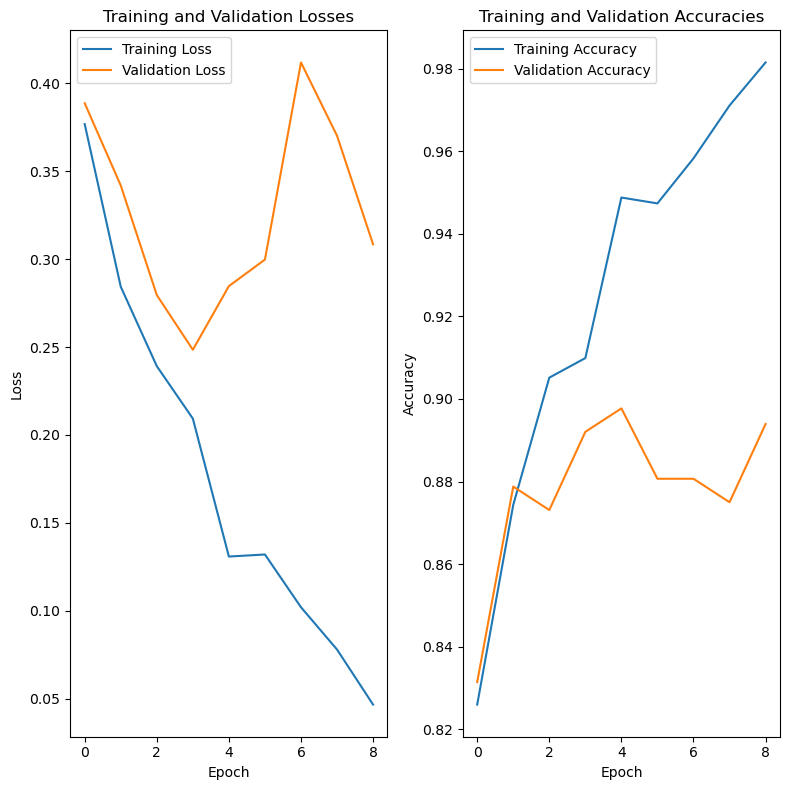

In [13]:
def plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

    for ax, data, title, ylabel in [
        (ax1, [(losses_train, 'Training Loss'), (losses_val, 'Validation Loss')],\
          'Training and Validation Losses', 'Loss'),
        (ax2, [(accuracies_train, 'Training Accuracy'), (accuracies_val, 'Validation Accuracy')],\
          'Training and Validation Accuracies', 'Accuracy'),
    ]:
        for data, label in data:
            ax.plot(data, label=label)
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend()

    plt.tight_layout()

plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val)